## Managing data

### The purpose of this file

In this notebook I will process the data I found good enough, and will create the final dataset that will be suitable for training the machine learning model on.
The datasets provided by the Micro:bits are accelartion-time or angle-time data series, and there are plenty of them. I would like to create one record to each experiment in my final dataset, so one point is going to represent one experiment in a 3 dimensional graph, in which the ML algorithm tries to classify the data points.
Hence, when I take one data series, I do the following:
 - I work out the range of the acceleration along the x-axis, using the formula: r_x = max(a_x)-min(a_x)
 - I work out the range of the acceleration along the y-axis, using the formula: r_y = max(a_y)-min(a_y)
 - I work out the range of tilt angle along the z-axis, using the formula: r_ang = max(ang)-min(ang)
 
The 4 dimensional point that represents one measurement will be as follows:
(r_x, r_y, r_ang, id)
where id is the identifier of the motion. These 4-dimensional points can be plotted in a 3-dimensional graph, where the axes represents a_x, a_y and ang, and the colour of the point (the 4th dimension) shows the id of the motion.

### Importing the important libraries

In [1]:
import pandas as pd
import os
import glob
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Accessing files and get the absolute paths to them

In [2]:
# accessing files

def get_files(filepath):
    all_files = []
    for root, dirs, files in os.walk(filepath):
        files = glob.glob(os.path.join(root, '*.txt'))
        for f in files:
            all_files.append(os.path.abspath(f))
            
        return all_files

In [3]:
# checking how the function works
all_files = get_files('Data')
print(f'The number if data files is {len(all_files)}')

The number if data files is 196


### Creating data frame from the files

In [4]:
# processing file

def process_file(datafile):
    myfile = open(datafile, 'r')
    datalist = myfile.readlines()
    data_to_frame = []
    for item in datalist:
        item = item.split(sep = ',')
        data_to_frame.append(item)
            
    df = pd.DataFrame(data = data_to_frame, columns = ['a_x', 'a_y', 'angle'])
    return df
        
        

### Converting data in the frame to numeric

In [5]:
# The data sent by the Micro:bit had to be in str format, but for processing the data we need it in numeric format.

def to_numeric(df):
    df['a_x'] = pd.to_numeric(df['a_x'])
    df['a_y'] = pd.to_numeric(df['a_y'])
    df['angle'] = pd.to_numeric(df['angle'])
    
    return df
    

### Creating the final dataset

In [6]:
'''
This function is designed to work out the range of the acceleration and of the angle. Due to the positioning of the Micro:bit,
the default angle for SHM is -90 degrees, and the range of the angle shows too much. However, we expect to have about zero
degrees rotation around the z-axis for this motion. So, I work out the range of angle differently for SHM and the other two motions.
The -120 degrees, that you can find in the code is based on empirical observations.
'''
def range_(df, id_):
    r_x = round(max(df['a_x'])-min(df['a_x']),1)
    r_y = round(max(df['a_y'])-min(df['a_y']),1)
    if id_ ==0:
        r_ang = round(max(df['angle'])-min(df['angle']),1)-120
    else:
        r_ang = round(max(df['angle'])-min(df['angle']),1)
        
    return r_x, r_y, r_ang

In [7]:
# I take each file, assign one instance to each file and add it to a list which will be converted to the final dataset

data_files = get_files('Data')
list_final = []
count_shm = 0
count_pend = 0
count_circ = 0


for i in range(len(data_files)):
    df = process_file(data_files[i])
    df = to_numeric(df)
    id_ = int(df['a_x'][0])
    if id_ ==0:
        r_x, r_y, r_ang = range_(df, id_)
        count_shm +=1
    elif id_ == 1:
        r_x, r_y, r_ang = range_(df, id_)   
        count_pend +=1
    else:
        r_x, r_y, r_ang = range_(df, id_)
        count_circ +=1
        
    new = [r_x, r_y, r_ang, id_]
    list_final.append(new)

final_dataset = pd.DataFrame(data = list_final, columns = ['r_x', 'r_y', 'r_ang', 'id'])
print(final_dataset.head())
print(f"The final dataset contains {count_shm} records to SHM, {count_pend} records to the pendulum and {count_circ} records to\
the circular motion.")
    



    

    r_x   r_y  r_ang  id
0  16.5   4.4  -18.5   0
1  19.5   5.2    1.1   0
2  19.5   4.5    6.5   0
3  12.4  15.9  107.3   1
4  20.4  28.9  355.8   2
The final dataset contains 69 records to SHM, 62 records to the pendulum and 65 records tothe circular motion.


In [8]:
# saving the final dataset
final_dataset.to_csv('final_dataset.csv')

### Visualizing the data instances

In [9]:
final_dataset.id.unique()

array([0, 1, 2], dtype=int64)

<IPython.core.display.Javascript object>


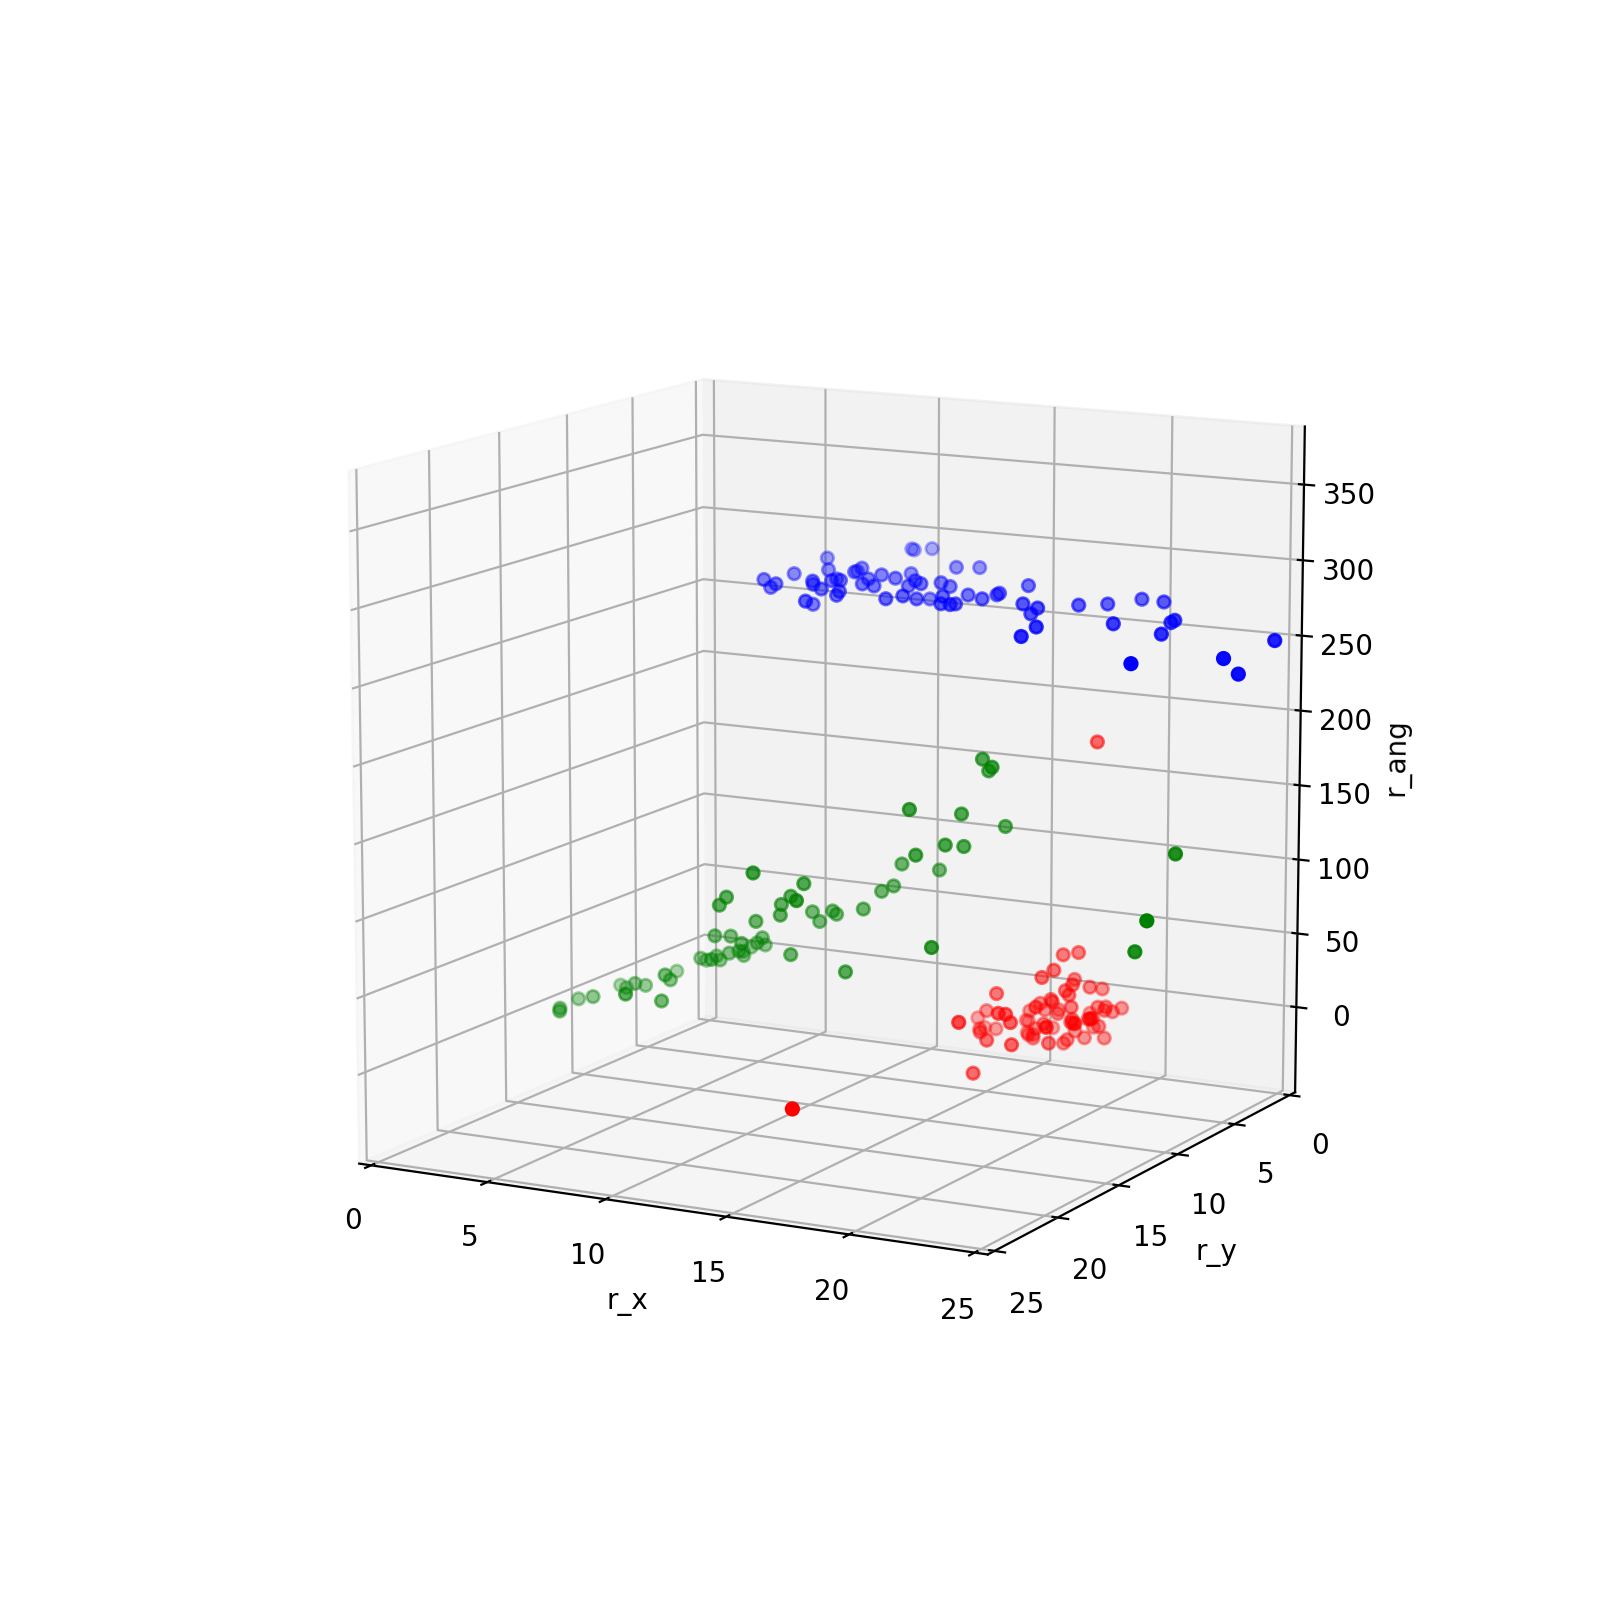

In [11]:
#plotting a 3 dimensional graph to show the data instances and find clusters if there is any
%matplotlib notebook

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111,projection = '3d')

ax.set_xlim(0,25)
ax.set_ylim(25,0)
ax.set_xlabel('r_x')
ax.set_ylabel('r_y')
ax.set_zlabel('r_ang')

r_x = final_dataset['r_x']
r_y = final_dataset['r_y']
r_ang = final_dataset['r_ang']

colours = ['r', 'g', 'b']

for i in final_dataset.id.unique():
    ax.scatter(final_dataset.r_x[final_dataset.id == i], final_dataset.r_y[final_dataset.id == i], 
               final_dataset.r_ang[final_dataset.id == i], c = colours[i])

plt.show()